# Calculating temporal variance with and without seasonal cycle

In [1]:
using CABLAB
using CABLAB.Mask

   A Cube is defined via its path and some a single variable is read into memory.

In [2]:
c     = Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/high-res")
cdata = getCubeData(c, variable="soil_moisture", latitude=(30,65), longitude=(-10,40))

Data Cube view with the following dimensions
Lon                 Axis with 600 Elements from -10.000679999999988 to 39.915787000000016
Lat                 Axis with 420 Elements from 65.0001 to 30.083573
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00


Here we demonstrate how to add a user-defined function to use the DAT's capabilities. First we define the function that has the signature *xin* (input data), *xout* (output data), *maskin* (input mask), *maskout* (output mask). In this case it simply cacluates the variance of a time series. Then we call registerDATFunction, makes the function simply callable thourgh mapCube. 

In [4]:
function varianceTime{T}(xout::AbstractArray{T,0},maskout::AbstractArray{UInt8,0},xin::AbstractVector{T},maskin::AbstractVector)
  s=0.0
  s2=0.0
  n=0
  for i in eachindex(xin)
    if maskin[i]==VALID
      s+=xin[i]
      s2+=xin[i]*xin[i]
      n+=1
    end
  end
  if n>0
    xout[1]=s2/n-(s/n)*(s/n)
    maskout[1]=VALID
  else
    maskout[1]=MISSING
  end
end

CABLAB.DAT.registerDATFunction(varianceTime,(TimeAxis,),());

Here we call the function with our 3D data cube as its argument.

In [5]:
v1             = mapCube(varianceTime,cdata, no_ocean=true);
cube_anomalies = mapCube(removeMSC,cdata, no_ocean=true);
v2             = mapCube(varianceTime,cube_anomalies, no_ocean=true);

We get the spatial mean of the time variances

And show the maps of variances:

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 0.0 
 0.0025 
 0.005 
 0.0075
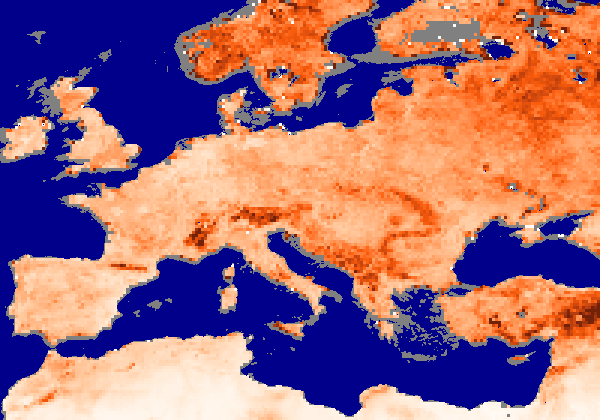

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 0.0 
 0.0025 
 0.005 
 0.0075
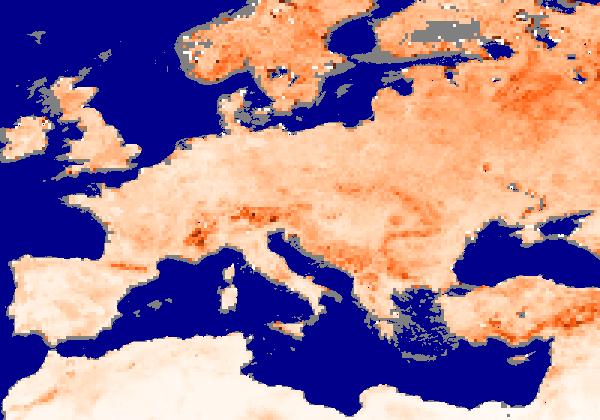

In [6]:
display(plotMAP(v1,dmin=0.0f0,dmax=0.01f0))
display(plotMAP(v2,dmin=0.0f0,dmax=0.01f0))

In [7]:
show(v1)

In-Memory data cube with the following dimensions
Lon                 Axis with 600 Elements from -10.000679999999988 to 39.915787000000016
Lat                 Axis with 420 Elements from 65.0001 to 30.083573


In [8]:
mv1=reduceCube(mean, v1, LatAxis, skipnull=true);
mv2=reduceCube(mean, v2, LatAxis, skipnull=true);
println("Mean variance with seasonal cycle: ", mv1.data[1])
println("Mean variance without seasonal cycle: ", mv2.data[1])

Mean variance with seasonal cycle: NaN
Mean variance without seasonal cycle: NaN
